In [66]:
!pip install pydicom pillow pylibjpeg-libjpeg pylibjpeg python-gdcm seaborn matplotlib SciPy
 

In [72]:
import os
#import seaborn as sns
#sns.set_theme()
import matplotlib.pyplot as plt
#from scipy.stats import spearmanr

NameError: name '_private' is not defined

In [51]:
import pandas as pd
import numpy as np
import pydicom
import glob
import gdcm
import pylibjpeg

ModuleNotFoundError: No module named 'Pillow'

In [2]:
ls

rnsa_cnn_init.ipynb               test_images/
rsna-breast-cancer-detection.zip  train.csv
sample_submission.csv             train_images/
test.csv


In [4]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [5]:
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [10]:
train_df["patient_id"].nunique()

11913

In [11]:
test_df.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


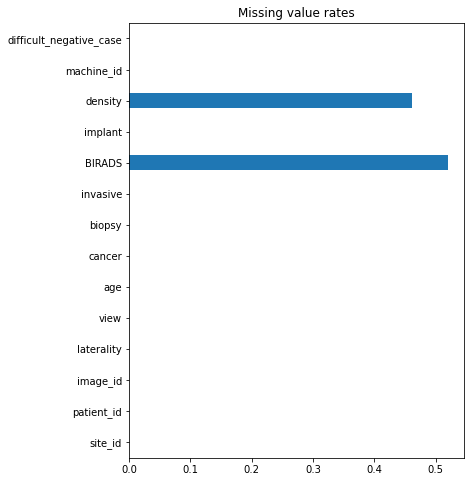

In [73]:
plt.figure(figsize=(6, 8))
train_df.isna().mean().plot(kind="barh")
plt.title("Missing value rates");

In [12]:
test_df.nunique()

site_id          1
patient_id       1
image_id         4
laterality       2
view             2
age              1
implant          1
machine_id       1
prediction_id    2
dtype: int64

In [17]:
train_images = glob.glob("train_images/*/*.dcm")
len(train_images)

54706

In [18]:
train_images[0]

'train_images/1069/1313414003.dcm'

In [48]:
train_image0 = pydicom.read_file(train_images[0])
print(train_image0)

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.1069.1.1313414003
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.1069.1.1313414003
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '184021.071147'
(0010, 0020) Patient ID                          LO: '1069'
(0020, 000d) Study Instance UID                  UI: 1.2.840.10009.1.2.3.1069
(0020, 000e) Series Instance UID

In [49]:
train_image0_array = train_image0.pixel_array

NotImplementedError: The pixel data with transfer syntax JPEG 2000 Image Compression (Lossless Only), cannot be read because Pillow lacks the JPEG 2000 plugin